[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Chex-Mix/pneumonia-detection/blob/master/chest_x.ipynb)

# Chex Mix: Improving Pneumonia Detection by Considering Existing Disease Labels
Blake List and Daniel Bentall

## Abstract


In [48]:
# Import the necessary libraries to use the Google Drive directories.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download image data set using its ID.
image_df = drive.CreateFile({'id': '1If9W6LymNNJGEa2U_TfgWcsUBCV6_GoI'})
image_df.GetContentFile('balanced_resized.zip')

# Unzip the image folder.
!unzip -q 'balanced_resized.zip'

replace resized/00000003_000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# Import the necessary packages for preprocessing and plotting.
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, neighbors, svm, calibration, tree
from sklearn.utils import shuffle
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline

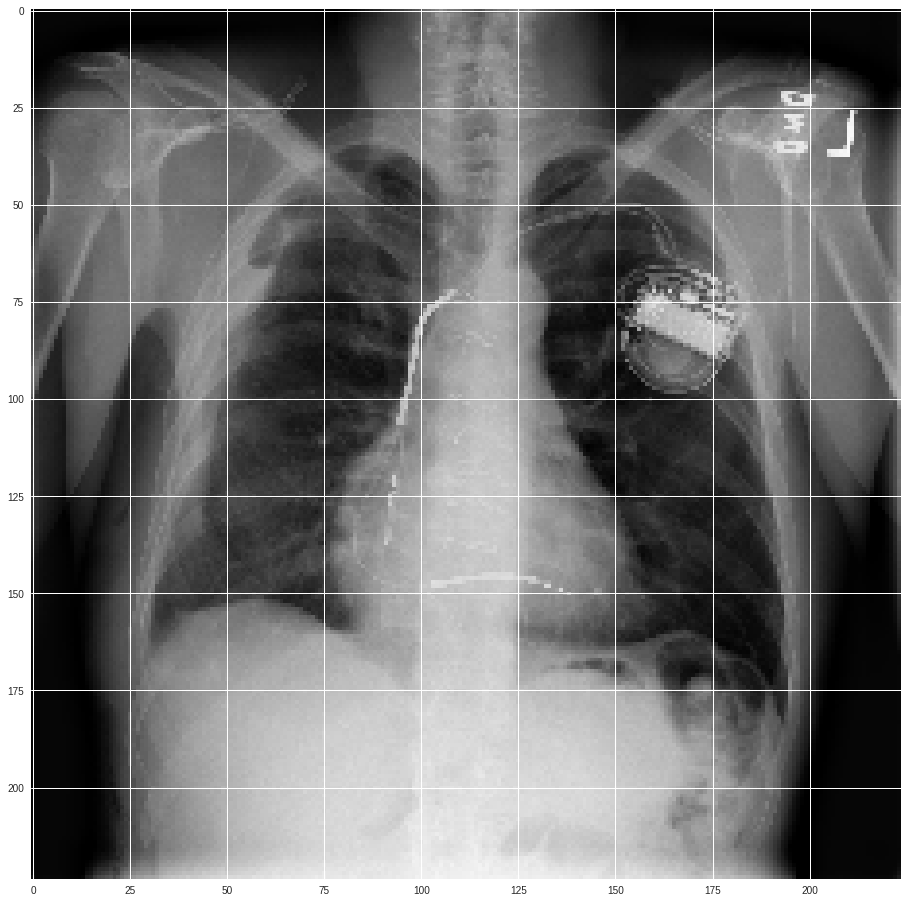

In [50]:
# https://matplotlib.org/users/image_tutorial.html
# https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html

# Plot an image and its shape from the folder to see what it looks like
image = cv2.imread("resized/00000013_041.png")
im_shape = image.shape

plt.figure(figsize=(16,16))
plt.imshow(image)
plt.show()

In [51]:
# Load in the label csv that includes the image index, thoracic pathologies and 
# basic patient information. Read in the dataframe and print it.
  
labels_data = drive.CreateFile({'id': '1SGohw8fB1J4QIRX2rr_uQa5158ZApqbk'})
labels_data.GetContentFile('balanced_resized_labels.csv')

with open('balanced_resized_labels.csv', 'r') as labels_df:
    labels_df = pd.read_csv('balanced_resized_labels.csv')
    
#labels_data = drive.CreateFile({'id': '1BRQMesGMIJuNBmHda2BHUs_F3izA8Ubt'})
#labels_data.GetContentFile('balanced_50_50_set_labels.csv')
#
#with open('balanced_50_50_set_labels.csv', 'r') as labels_df:
#  labels_df = pd.read_csv('balanced_50_50_set_labels.csv')
    
  
print(labels_df.head())

        Image Index             Finding Labels  Follow-up #  Patient ID  \
0  00014022_077.png                 No Finding           77       14022   
1  00014706_012.png  Cardiomegaly|Infiltration           12       14706   
2  00011460_032.png               Pneumothorax           32       11460   
3  00029259_010.png                  Emphysema           10       29259   
4  00012834_132.png         Pleural_Thickening          132       12834   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           66              M            AP                 2500     2048   
1           21              F            AP                 2500     2048   
2           16              M            PA                 2992     2991   
3           34              F            AP                 3056     2544   
4           33              M            AP                 2500     2048   

   OriginalImagePixelSpacing[x     y]  X12  
0                        0.168  0.168  Na

In [0]:
# Extract only the columns that are needed for the preprocessing of the 
# dataframe for the logistic model
df = labels_df.loc[:, ['Image Index', 'Patient Age', 'Patient Gender', 'Follow-up #']]

In [0]:
# Create a separate dataframe containing the labels column.
df_labs = labels_df.loc[:, ['Finding Labels']]

In [0]:
# Create a list of all the labels that will be extracted from the labels column.
labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
          'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Nodule',
          'Pleural_Thickening', 'Cardiomegaly', 'Mass', 'Hernia']

In [0]:
# Create a function to extract each disease as a boolean for each row; True 
# where the disease is present in Finding Labels, False otherwise.
# Append it as its own column back to 'df' that will be used for the logistic.
def label_finder(label):
    df[label] = df_labs[df_labs['Finding Labels'].str.contains(label)]
    df[label] = df[label].notnull()

In [0]:
# Iterate over the list of labels and pass to the disease finder function.
for label in labels:
  label_finder(str(label))

In [0]:
# Convert the patient genders to booleans, where male is True.
df['Patient Gender'] = df['Patient Gender'] == 'M'

In [58]:
# Print the dataframe so far. We can see that all diseases are in separate
# columns as booleans. These will all be encoded to 1/0 for the logistic model.
print(df.head())

        Image Index  Patient Age  Patient Gender  Follow-up #  Atelectasis  \
0  00014022_077.png           66            True           77        False   
1  00014706_012.png           21           False           12        False   
2  00011460_032.png           16            True           32        False   
3  00029259_010.png           34           False           10        False   
4  00012834_132.png           33            True          132        False   

   Consolidation  Infiltration  Pneumothorax  Edema  Emphysema  Fibrosis  \
0          False         False         False  False      False     False   
1          False          True         False  False      False     False   
2          False         False          True  False      False     False   
3          False         False         False  False       True     False   
4          False         False         False  False      False     False   

   Effusion  Pneumonia  Nodule  Pleural_Thickening  Cardiomegaly   Mass  \

In [0]:
# Apply Sklearn's label encoder to convert the boolean columns from True/False 
# to 1/0.
df = df.select_dtypes(exclude=['object', 'number']).apply(LabelEncoder().fit_transform).join(df.select_dtypes(include=['object', 'number']))

In [60]:
# Print out the dataframe again.
print(df.head())

   Patient Gender  Atelectasis  Consolidation  Infiltration  Pneumothorax  \
0               1            0              0             0             0   
1               0            0              0             1             0   
2               1            0              0             0             1   
3               0            0              0             0             0   
4               1            0              0             0             0   

   Edema  Emphysema  Fibrosis  Effusion  Pneumonia  Nodule  \
0      0          0         0         0          0       0   
1      0          0         0         0          0       0   
2      0          0         0         0          0       0   
3      0          1         0         0          0       0   
4      0          0         0         0          0       0   

   Pleural_Thickening  Cardiomegaly  Mass  Hernia       Image Index  \
0                   0             0     0       0  00014022_077.png   
1                   0 

In [61]:
# Set the image size and input shape. Extract the image arrays and resize them 
# to the specified input shape then append them to a list.
img_size = 168

input_shape = (img_size, img_size, 3)

X = []

for image_filename in tqdm(df['Image Index']):       
  img_file = cv2.imread('resized' + '/' + image_filename)
  img_file = scipy.misc.imresize(arr=img_file, size=input_shape)
  img_arr = np.asarray(img_file)
  X.append(img_arr)

  0%|          | 0/29100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
100%|██████████| 29100/29100 [00:58<00:00, 502.81it/s]


In [0]:
# Convert the list of image arrays to a Pandas series and create a new column
# in the full dataframe with its values as the column elements.
X = pd.Series(X)
df['img_arr'] = X.values

In [63]:
print(df.head())
print(df.shape)

   Patient Gender  Atelectasis  Consolidation  Infiltration  Pneumothorax  \
0               1            0              0             0             0   
1               0            0              0             1             0   
2               1            0              0             0             1   
3               0            0              0             0             0   
4               1            0              0             0             0   

   Edema  Emphysema  Fibrosis  Effusion  Pneumonia  Nodule  \
0      0          0         0         0          0       0   
1      0          0         0         0          0       0   
2      0          0         0         0          0       0   
3      0          1         0         0          0       0   
4      0          0         0         0          0       0   

   Pleural_Thickening  Cardiomegaly  Mass  Hernia       Image Index  \
0                   0             0     0       0  00014022_077.png   
1                   0 

In [64]:
labels_data = drive.CreateFile({'id': '1lRMSsJZXaJBl3ajhcK-oIs5KroyMFiQp'})
labels_data.GetContentFile('train_val_list.txt')

with open('train_val_list.txt', 'r') as f:
    train_list = [x.strip() for x in f.readlines()]
  
  
train_list = pd.DataFrame({'Image Index' : train_list})
print(train_list.head())

        Image Index
0  00000001_000.png
1  00000001_001.png
2  00000001_002.png
3  00000002_000.png
4  00000004_000.png


In [65]:
labels_data = drive.CreateFile({'id': '1P9xhlHs5aulb0UjsryjDmLdugGRC6lDu'})
labels_data.GetContentFile('test_list.txt')

with open('test_list.txt', 'r') as f:
    test_list = [x.strip() for x in f.readlines()]
  
  
test_list = pd.DataFrame({'Image Index' : test_list})
print(test_list.head())

        Image Index
0  00000003_000.png
1  00000003_001.png
2  00000003_002.png
3  00000003_003.png
4  00000003_004.png


In [0]:
train = pd.merge(df, train_list, on='Image Index', how='inner')
test = pd.merge(df, test_list, on='Image Index', how='inner')

In [67]:
print(train.shape)
print(test.shape)

(3504, 19)
(25596, 19)


In [0]:
#train = shuffle(train)
#test = shuffle(test)

In [0]:
train, validate = train_test_split(train, test_size=0.25, random_state=1)

In [0]:
X_train = train.drop(['Pneumonia'], axis=1)
X_test = test.drop(['Pneumonia'], axis=1)
y_train = train['Pneumonia']
y_test = test['Pneumonia']

In [0]:
X_validate = validate.drop(['Pneumonia'], axis=1)
y_validate = validate['Pneumonia']

In [0]:
# Encode labels to hot vectors (ex : 1 -> [0,1])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_validateHot = to_categorical(y_validate, num_classes = 2)

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_trainHot.shape)
print(y_testHot.shape)

(2628, 18)
(2628,)
(25596, 18)
(25596,)
(2628, 2)
(25596, 2)


In [0]:
import keras
#see https://keras.io/applications/ for information on customization

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras import optimizers
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D
from keras import backend as K


# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dense(8, activation='relu')(x)

# and a logistic layer
predictions = Dense(2, activation='softmax')(x)


# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [75]:
train_list = np.asarray(X_train['img_arr'].tolist())
print(train_list.shape)

(2628, 168, 168, 3)


In [0]:
#http://www.deepideas.net/unbalanced-classes-machine-learning/

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
  
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_predicited_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (total_predicited_positives + K.epsilon())
  
def f1_score(precision, recall):
    return 2*((precision*recall)/(precision+recall))


In [77]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# train the model on the new data for a few epochs

model.fit(np.asarray(X_train['img_arr'].tolist()), y_trainHot, epochs=10)


#datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

#datagen.fit(train_list)
#model.fit_generator(datagen.flow(train_list, y_trainHot, batch_size=32), steps_per_epoch=100, epochs=30)

Epoch 1/10
2628/2628 [==============================] - 17s 6ms/step - loss: 0.5879 - acc: 0.7249
Epoch 2/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.5176 - acc: 0.7462
Epoch 3/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.4911 - acc: 0.7489
Epoch 4/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.4518 - acc: 0.7599
Epoch 5/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.4120 - acc: 0.8002
Epoch 6/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.3681 - acc: 0.8288
Epoch 7/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.3162 - acc: 0.8676
Epoch 8/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.2737 - acc: 0.8801
Epoch 9/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.2163 - acc: 0.9189
Epoch 10/10
2628/2628 [==============================] - 12s 5ms/step - loss: 0.1664 - acc: 0.9425


In [78]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 zero_padding2d_3
2 conv1/conv
3 conv1/bn
4 conv1/relu
5 zero_padding2d_4
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_block

In [0]:
# we chose to train the top 3 Dense blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:313]:
   layer.trainable = False
for layer in model.layers[313:]:
   layer.trainable = True

In [0]:
# we need to recompile the model for these modifications to take effect
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [81]:
# we train our model again
model.fit(np.asarray(X_train['img_arr'].tolist()), y_trainHot, epochs=10)

#datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

#datagen.fit(train_list)
#history = model.fit_generator(datagen.flow(train_list, y_trainHot, batch_size=32), steps_per_epoch=100, epochs=30)


# list all data in history
#print(history.history.keys())


# plotting accuracy and loss against epoch count
#plt.plot(history.history['precision'])
#plt.plot(history.history['recall'])
#plt.title('Model Precision vs. Recall')
#plt.ylabel('Precision')
#plt.xlabel('Loss')
#plt.legend(['Precision', 'Recall'], loc='upper left')
#plt.show()

Epoch 1/10
2628/2628 [==============================] - 26s 10ms/step - loss: 0.5852 - acc: 0.7359
Epoch 2/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.3642 - acc: 0.8436
Epoch 3/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.2705 - acc: 0.8900
Epoch 4/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.1874 - acc: 0.9285
Epoch 5/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.1512 - acc: 0.9437
Epoch 6/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.0735 - acc: 0.9768
Epoch 7/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.0885 - acc: 0.9707
Epoch 8/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.0876 - acc: 0.9669
Epoch 9/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.0693 - acc: 0.9756
Epoch 10/10
2628/2628 [==============================] - 16s 6ms/step - loss: 0.1622 - acc: 0.9456


             precision    recall  f1-score   support

 No Finding       0.82      0.26      0.39       671
  Pneumonia       0.25      0.82      0.39       205

avg / total       0.69      0.39      0.39       876



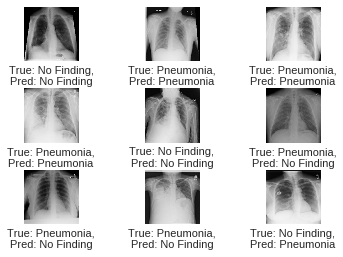

acc: 0.39


In [82]:
labels = ['No Finding', 'Pneumonia']

#test_x = np.asarray(X_test['img_arr'].tolist())
validation = np.asarray(X_validate['img_arr'].tolist()) 
preds = model.predict(validation)

cls_pred = np.argmax(preds, axis=1)
print(sklearn.metrics.classification_report(y_validate, cls_pred, target_names=labels))

img_shape = (img_size, img_size, 3)

#show the images

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(labels[cls_true[i]-1])
        else:
            xlabel = "True: {0},\nPred: {1}".format(labels[cls_true[i]-1],
                                                    labels[cls_pred[i]-1])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
      

plot_images(validation[0:9], np.argmax(y_validateHot[0:9], axis=1), cls_pred[0:9])

print("acc: %.02f" % sklearn.metrics.accuracy_score(y_validate, cls_pred))

Average precision-recall score: 0.25


Text(0.5,1,'2-class Precision-Recall curve: AP=0.25')

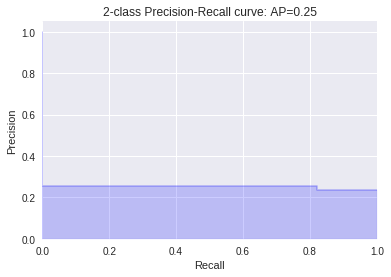

In [83]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_validate, cls_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_validate, cls_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [0]:
feature_layer = Model(inputs=model.input, outputs=model.get_layer(index=428).output)

pool_features_train = feature_layer.predict(np.asarray(X_train['img_arr'].tolist()))

pool_features_test = feature_layer.predict(np.asarray(X_test['img_arr'].tolist()))

In [0]:
pool_features_validate = feature_layer.predict(np.asarray(X_validate['img_arr'].tolist()))

In [86]:
print(pool_features_train.shape)
print(pool_features_test.shape)
print(pool_features_validate.shape)

(2628, 8)
(25596, 8)
(876, 8)


In [0]:
pool_features_train = pd.DataFrame(pool_features_train)
pool_features_test = pd.DataFrame(pool_features_test)
pool_features_validate = pd.DataFrame(pool_features_validate)

In [0]:
X_train = X_train.drop(['img_arr'], axis=1)
X_test = X_test.drop(['img_arr'], axis=1)
X_validate = X_validate.drop(['img_arr'], axis=1)

In [0]:
X_train_log = pd.concat([X_train.reset_index(drop=True), pool_features_train], axis=1)
X_test_log = pd.concat([X_test.reset_index(drop=True), pool_features_test], axis=1)
X_validate_log = pd.concat([X_validate.reset_index(drop=True), pool_features_validate], axis=1)

In [90]:
print(X_train_log.head())
print(X_test_log.head())
print(X_validate_log.head())

   Patient Gender  Atelectasis  Consolidation  Infiltration  Pneumothorax  \
0               1            0              0             0             0   
1               1            0              0             0             0   
2               1            0              0             0             0   
3               1            0              0             0             0   
4               0            0              0             0             0   

   Edema  Emphysema  Fibrosis  Effusion  Nodule ...   Patient Age  \
0      0          0         0         0       0 ...            47   
1      0          0         0         0       0 ...            27   
2      0          0         0         0       0 ...            56   
3      0          0         0         0       0 ...            11   
4      0          0         0         0       0 ...            27   

   Follow-up #          0    1          2          3          4          5  \
0            0   0.000000  0.0  14.868183   

In [0]:
y_train_log = y_train
y_test_log = y_test
y_validate_log = y_validate

In [0]:
X_train_log = X_train_log.drop(['Image Index'], axis=1)
X_test_log = X_test_log.drop(['Image Index'], axis=1)
X_validate_log = X_validate_log.drop(['Image Index'], axis=1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False): 0.776256
             precision    recall  f1-score   support

          0       0.80      0.94      0.87       671
          1       0.55      0.24      0.34       205

avg / total       0.74      0.78      0.74       876



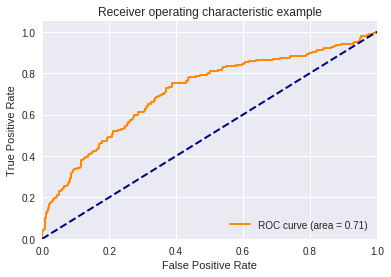

acc: 0.78
    Coefficients             Feature
0       0.081841      Patient Gender
1       0.918872         Atelectasis
2       0.352090       Consolidation
3       0.909561        Infiltration
4      -0.931607        Pneumothorax
5       2.530750               Edema
6       0.296475           Emphysema
7      -0.816532            Fibrosis
8       0.343754            Effusion
9      -0.205340              Nodule
10      0.014316  Pleural_Thickening
11      0.208644        Cardiomegaly
12      0.216167                Mass
13     -0.631311              Hernia
14     -0.006842         Patient Age
15      0.015852         Follow-up #
16     -0.005406                   0
17      0.000000                   1
18     -0.007504                   2
19      0.028316                   3
20      0.008870                   4
21      0.003410                   5
22      0.000296                   6
23     -0.182622                   7


In [93]:
def test_model(model):
  model.fit(X_train_log, y_train_log)
  y_predict = model.predict(X_validate_log)
  print("%s: %f" % (str(model), metrics.accuracy_score(y_validate_log, y_predict)))
  print(metrics.classification_report(y_validate_log, y_predict))
  y_predict_proba = model.predict_proba(X_validate_log)
  
  fpr, tpr, _ = metrics.roc_curve(y_validate_log, y_predict_proba[:,1])
  roc_auc = metrics.auc(fpr, tpr)
  
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()
  
  print("acc: %.02f" % sklearn.metrics.accuracy_score(y_validate_log, np.argmax(y_predict_proba, axis=1)))
    
  
  coefficients = pd.DataFrame({"Coefficients":np.transpose(model.coef_[0, ]), "Feature":X_train_log.columns})
  print(coefficients)
  
test_model(LogisticRegression())

In [94]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


#model.fit(X_train, y_trainHot, epochs=5)

# define the rotations, shifts and flips of the image data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                          height_shift_range=0.1,
                                                          width_shift_range=0.1,
                                                          horizontal_flip=True)

datagen.fit(X_train)
model.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32), steps_per_epoch=10, epochs=5,workers=1)

ValueError: ignored

In [11]:
# fix this!!!

model = tf.keras.models.Sequential()


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


datagen = tf.keras.preprocessing.image.ImageDataGenerator()
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32), epochs=10)


# list all data in history
print(history.history.keys())


# plotting accuracy and loss against epoch count
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Y')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper right')
plt.show()

ValueError: ignored